# Split Learning—Bank Marketing—Torch Backend

>The following codes are demos only. It's **NOT for production** due to system security concerns, please **DO NOT** use it directly in production.

In this tutorial, we will use the bank's marketing model as an example to show how to accomplish split learning in vertical scenarios under the SecretFlow framework.
SecretFlow provides a user-friendly Api that makes it easy to apply your Keras model or PyTorch model to split learning scenarios to complete joint modeling tasks for vertical scenarios.

In this tutorial we will show you how to turn your existing 'Keras' model into a split learning model under Secretflow to complete federated multi-party modeling tasks.

## What is Split Learning？

The core idea of split learning is to split the network structure. Each device (silo) retains only a part of the network structure, and the sub-network structure of all devices is combined together to form a complete network model. 
In the training process, different devices (silos) only perform forward or reverse calculation on the local network structure, and transfer the calculation results to the next device. Multiple devices complete the training through joint model until convergence.

 <img alt="split_learning_tutorial.png" src="resources/split_learning_tutorial.png" width="600">  


**Alice**：have *data\_alice*，*model\_base\_alice*  
**Bob**: have *data\_bob*，*model\_base\_bob*，*model\_fuse*  

1. **Alice** uses its data to get *hidden0* through *model\_base\_Alice* and send it to Bob. 
2. **Bob** gets *hidden1* with its data through *model\_base\_bob*.
3. *hidden\_0* and *hidden\_1* are input to the *AggLayer* for aggregation, and the aggregated *hidden\_merge* is the output.
4. **Bob** input *hidden\_merge* to *model\_fuse*, get the gradient with *label* and send it back.
5. The gradient is split into two parts *g\_0*, *g\_1* through *AggLayer*, which are sent to **Alice** and **Bob** respectively.
6. Then **Alice** and **Bob** update their local base net with *g\_0* or *g\_1*.


## Task

Marketing is the banking industry in the ever-changing market environment, to meet the needs of customers, to achieve business objectives of the overall operation and sales activities. In the current environment of big data, data analysis provides a more effective analysis means for the banking industry. Customer demand analysis, understanding of target market trends and more macro market strategies can provide the basis and direction.  
  
The data from [kaggle](https://www.kaggle.com/janiobachmann/bank-marketing-dataset) is a set of classic marketing data bank, is a Portuguese bank agency telephone direct marketing activities, The target variable is whether the customer subscribes to deposit product.

## Data

1. The total sample size was 11162, including 8929 training set and 2233 test set.
2. Feature dim is 16, target is binary classification.
3. We have cut the data in advance. Alice holds the 4-dimensional basic attribute features, Bob holds the 12-dimensional bank transaction features, and only Alice holds the corresponding label.

Let's start by looking at what our bank's marketing data look like?  

The original data is divided into Bank Alice and Bank Bob, which stores in Alice and Bob respectively. Here, CSV is the original data that has only been separated without pre-processing, we will use `secretflow preprocess` for FedData preprocess.

In [462]:
%load_ext autoreload
%autoreload 2

import secretflow as sf
import matplotlib.pyplot as plt
sf.shutdown()

sf.init(['alice', 'bob'], address='local',num_cpus=8)
alice, bob = sf.PYU('alice'), sf.PYU('bob')

2023-09-22 14:51:42,272	INFO worker.py:1538 -- Started a local Ray instance.


### prepare data

In [463]:
import pandas as pd
from secretflow.utils.simulation.datasets import dataset
import numpy as np
df = pd.read_csv(dataset('bank_marketing'), sep=';')

We assume that Alice is a new bank, and they only have the basic information of the user and purchased the label of financial products from other bank.

In [464]:
alice_data = df[["age", "job", "marital", "education", "y"]]
alice_data

,age,job,marital,education,y
0,30,unemployed,married,primary,no
1,33,services,married,secondary,no
2,35,management,single,tertiary,no
3,30,management,married,tertiary,no
4,59,blue-collar,married,secondary,no
...,...,...,...,...,...
4516,33,services,married,secondary,no
4517,57,self-employed,married,tertiary,no
4518,57,technician,married,secondary,no
4519,28,blue-collar,married,secondary,no


Bob is an old bank, they have the user's account balance, house, loan, and recent marketing feedback.

In [465]:
bob_data = df[
    [
        "default",
        "balance",
        "housing",
        "loan",
        "contact",
        "day",
        "month",
        "duration",
        "campaign",
        "pdays",
        "previous",
        "poutcome",
    ]
]
bob_data

,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown
1,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure
2,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure
3,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown
4,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
4516,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown
4517,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown
4518,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown
4519,no,1137,no,no,cellular,6,feb,129,4,211,3,other


## Create Secretflow Environment

Create 2 entities in the Secretflow environment [Alice, Bob]  
Where 'Alice' and 'Bob' are two `PYU`.  
Once you've constructed the two objects, you can happily start Splitting Learning.

### Import Dependency

In [466]:
from secretflow.data.split import train_test_split
from secretflow.ml.nn import SLModel

## Prepare Data

**Build Federated Table**


Federated table is a virtual concept that cross multiple parties, We define `VDataFrame` for vertical setting
.  

1. The data of all parties in a federated table is stored locally and is not allowed to go out of the domain.

2. No one has access to data store except the party that owns the data.

3. Any operation performed on the federated table is scheduled by the driver to each worker, and the execution instructions are delivered layer by layer until the Python runtime of the specific worker. The framework ensures that only the worker with `worker.device` equal to the `Object.device` can operate on the data.

4. Federated tables are designed for managing and manipulating multi-party data from a central perspective.

5. Interfaces to `Federated Tables` are aligned to `pandas.DataFrame` to reduce the cost of multi-party data operations.

6. The SecretFlow framework provides Plain&Ciphertext hybrid programming capabilities. Vertical federated tables are built using `SPU`, and `MPC-PSI` is used to safely get intersection and align data from all parties.

<img alt="vdataframe.png" src="resources/vdataframe.png" width="600">  



VDataFrame provides `read_csv` interface similar to pandas, the difference is that `secretflow.read_csv` receives a dictionary that defines the path of data for both parties. We can use `secretflow.vertical.read_csv` to build the `VDataFrame`.
```
read_csv(file_dict,delimiter,ppu,keys,drop_key)
    filepath: Path of the participant file. The address can be a relative or absolute path to a local file
    spu: SPU Device for PSI; If this parameter is not specified, data must be prealigned
    keys: Key for intersection.
```

Create spu object

In [467]:
spu = sf.SPU(sf.utils.testing.cluster_def(['alice', 'bob']))

In [468]:
from secretflow.utils.simulation.datasets import load_bank_marketing

# Alice has the first four features,
# while bob has the left features
data = load_bank_marketing(parts={alice: (0, 4), bob: (4, 16)}, axis=1)
# Alice holds the label.
label = load_bank_marketing(parts={alice: (16, 17)}, axis=1)

`data` is a vertically federated table. It only has the `Schema` of all the data globally.

Let's examine the data management of `VDF` more closely.

As shown in the example, the `age` field belongs to `Alice`, so the corresponding column can be obtained from `Alice`'s partition. However, if `Bob` tries to obtain the `age` field, a `KeyError` error will be reported.

We have a concept called Partition, which is a defined data fragment. Each partition has its own device to which it belongs, and only the device to which it belongs can operate on its data.

In [469]:
data['age'].partitions[alice].data

In [470]:
# You can uncomment this and you will get a KeyError.
# data['age'].partitions[bob]

Next, we perform data preprocessing on the `VDataFrame`.   
We use LabelEncoder and MinMaxScaler as examples. These two preprocessing functions have corresponding concepts in SkLearn, and their usage methods are similar to those in **sklearn**.

In [471]:
from secretflow.preprocessing.scaler import MinMaxScaler
from secretflow.preprocessing.encoder import LabelEncoder

In [472]:
encoder = LabelEncoder()
data['job'] = encoder.fit_transform(data['job'])
data['marital'] = encoder.fit_transform(data['marital'])
data['education'] = encoder.fit_transform(data['education'])
data['default'] = encoder.fit_transform(data['default'])
data['housing'] = encoder.fit_transform(data['housing'])
data['loan'] = encoder.fit_transform(data['loan'])
data['contact'] = encoder.fit_transform(data['contact'])
data['poutcome'] = encoder.fit_transform(data['poutcome'])
data['month'] = encoder.fit_transform(data['month'])
label = encoder.fit_transform(label)

(SPURuntime pid=25362) 2023-09-22 14:51:45.109 [info] [default_brpc_retry_policy.cc:DoRetry:52] socket error, sleep=1000000us and retry


In [473]:
print(f"label= {type(label)},\ndata = {type(data)}")

label= <class 'secretflow.data.vertical.dataframe.VDataFrame'>,
data = <class 'secretflow.data.vertical.dataframe.VDataFrame'>


Standardize data via MinMaxScaler

In [474]:
scaler = MinMaxScaler()

data = scaler.fit_transform(data)

(SPURuntime pid=25362) 2023-09-22 14:51:46.109 [info] [default_brpc_retry_policy.cc:LogHttpDetail:29] cntl ErrorCode '112', http status code '200', response header '', error msg '[E111]Fail to connect Socket{id=0 addr=127.0.0.1:43875} (0x0x359a400): Connection refused [R1][E112]Not connected to 127.0.0.1:43875 yet, server_id=0'
(SPURuntime pid=25362) 2023-09-22 14:51:46.109 [info] [default_brpc_retry_policy.cc:DoRetry:75] aggressive retry, sleep=1000000us and retry


Next we divide the data set into train-set and test-set, and change the default dtype (float64) to float32 to be the same as model parameters.

In [475]:
from secretflow.data.split import train_test_split
random_state = 1234
train_data,test_data = train_test_split(data, train_size=0.8, random_state=random_state)
train_label,test_label = train_test_split(label, train_size=0.8, random_state=random_state)
train_data=train_data.astype('float32')
test_data=test_data.astype('float32')
train_label=train_label.astype('float32')
test_label=test_label.astype('float32')

(_run pid=24406) /home/zhd/anaconda3/envs/sf-new/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
(_run pid=24406)   warnings.warn(
(_run pid=24406) /home/zhd/anaconda3/envs/sf-new/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
(_run pid=24406)   warnings.warn(


**Summary:** At this stage, we have finished defining `federated tables`, performing `data preprocessing`, and partitioning the `training set` and `test set`.
The secretFlow framework defines a set of operations to be built on the federated table (which is the logical counterpart of `pandas.DataFrame`). The secretflow framework defines a set of operations to be built on the federated table (its logical counterpart is `sklearn`) Refer to our documentation and API introduction to learn more about other features.

## Introduce Model

**local version**: 
For this task, a simple DNN can be trained to take in 16-dimensional features, process them through a neural network, and output the probability of positive and negative samples.


**Federate version**:  

* Alice:  

    - base_net: Input 4-dimensional feature and go through a DNN network to get hidden.  
    
    - fuse_net: Receive hidden features calculated by Alice and Bob, input them to fusenet for feature fusion, and complete the forward process and backward process.  
    
* Bob:  

    - base_net: Input 12-dimensional features, get hidden through a DNN network, and then send hidden to Alice to complete the following operation.  


### Define Model

Next, we will start creating the Split model.  

We have defined the SLTFModel and SLTorchModel, which are used to build split learning for vertically partitioned data. We have also created a simple and easy-to-use extensible interface, allowing you to easily transform your existing model into an SF-Model and perform vertically partitioned federated modeling.

Split learning is to break up a model so that one part is executed locally on the data and the other part is executed on the label side.
First let's define the locally executed model -- base_model.

In [476]:
from secretflow.ml.nn.utils import BaseModule
import torch
from torch import nn, optim
from torchmetrics import Accuracy, Precision, AUROC
from torchmetrics.classification import BinaryAccuracy,BinaryPrecision,BinaryAUROC
from secretflow.device import reveal
from secretflow.ml.nn import SLModel
from secretflow.ml.nn.fl.utils import metric_wrapper, optim_wrapper
from secretflow.ml.nn.utils import TorchModel
from secretflow.utils.compressor import TopkSparse

loss_fn=nn.BCELoss
optim_fn = optim_wrapper(optim.Adam, lr=1e-2)

class Base_Model_A(BaseModule):
    def __init__(self):
        super(Base_Model_A,self).__init__()
        self.layer1=nn.Linear(in_features=4,out_features=100)
        self.layer2=nn.ReLU()
        self.layer3=nn.Linear(100,64)
        self.layer4=nn.ReLU()
    def forward(self, x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        out=self.layer4(x)
        return out
    def output_num(self):
        return 1
class Base_Model_B(BaseModule):
    def __init__(self):
        super(Base_Model_B,self).__init__()
        self.layer1=nn.Linear(in_features=12,out_features=100)
        self.layer2=nn.ReLU()
        self.layer3=nn.Linear(100,64)
        self.layer4=nn.ReLU()
    def forward(self, x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        out=self.layer4(x)
        return out
    def output_num(self):
        return 1


model_base_alice = TorchModel(
    model_fn=Base_Model_A,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
)
model_base_bob = TorchModel(
    model_fn=Base_Model_B,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
)



In [477]:
model_base_alice.model_fn()
model_base_bob.model_fn()

Base_Model_B(
  (layer1): Linear(in_features=12, out_features=100, bias=True)
  (layer2): ReLU()
  (layer3): Linear(in_features=100, out_features=64, bias=True)
  (layer4): ReLU()
)

Next we define the side with the label, or the server-side model -- fuse_model.

In [478]:
class FuseModel(BaseModule):
    def __init__(self):
        super(FuseModel,self).__init__()
        self.layer1=nn.Linear(in_features=128,out_features=64)
        self.layer2=nn.ReLU()
        self.layer3=nn.Linear(64,1)
        self.layer4=nn.Sigmoid()
    def forward(self, x):
        x=torch.cat(x,dim=1)
        x = x.view(-1, 128)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        out=self.layer4(x)
        return out
model_fuse = TorchModel(
    model_fn=FuseModel,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(BinaryAccuracy),
        metric_wrapper(BinaryPrecision),
        metric_wrapper(BinaryAUROC),
    ],
)

In [479]:
model_fuse.model_fn()

FuseModel(
  (layer1): Linear(in_features=128, out_features=64, bias=True)
  (layer2): ReLU()
  (layer3): Linear(in_features=64, out_features=1, bias=True)
  (layer4): Sigmoid()
)

### Create Split Learning Model  
Secretflow provides the split learning model `SLModel`.  
To initial SLModel only need 3 parameters.  

* base_model_dict: A dictionary needs to be passed in all clients participating in the training along with base_model mappings  
* device_y: PYU, which device has label  
* model_fuse: The fusion model  

Define base_model_dict.  
```python
base_model_dict:Dict[PYU,model_fn]
```

In [480]:
base_model_dict = {
    alice: model_base_alice,
    bob:   model_base_bob
}

In [481]:
from secretflow.security.privacy.mechanism.torch import GaussianEmbeddingDP
from secretflow.security.privacy.mechanism.label_dp import LabelDP
from secretflow.security.privacy import DPStrategy
# # Define DP operations
train_batch_size = 128
dp_spent_step_freq = 10
gaussian_embedding_dp = GaussianEmbeddingDP(
    noise_multiplier=0.5,
    l2_norm_clip=1.0,
    batch_size=train_batch_size,
    num_samples=train_data.values.partition_shape()[alice][0],
    is_secure_generator=False,
)
dp_strategy_alice = DPStrategy(embedding_dp=gaussian_embedding_dp)
label_dp = LabelDP(eps=64.0)
dp_strategy_bob = DPStrategy(label_dp=label_dp)
dp_strategy_dict = {
    alice: dp_strategy_alice,
    bob: dp_strategy_bob,
}

In [482]:
sl_model = SLModel(
    base_model_dict=base_model_dict,
    device_y=alice,
    model_fuse=model_fuse,
    dp_strategy_dict=dp_strategy_dict,
    random_seed=random_state,
    backend='torch')

INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party bob.


In [483]:
sf.reveal(test_data.partitions[alice].data), sf.reveal(test_label.partitions[alice].data)

(           age       job  marital  education
 1426  0.279412  0.181818      0.5   0.333333
 416   0.176471  0.636364      1.0   0.333333
 3977  0.264706  0.000000      0.5   0.666667
 2291  0.338235  0.000000      0.5   0.333333
 257   0.132353  0.909091      1.0   0.333333
 ...        ...       ...      ...        ...
 1508  0.264706  0.818182      1.0   0.333333
 979   0.544118  0.090909      0.0   0.000000
 3494  0.455882  0.090909      0.5   0.000000
 42    0.485294  0.090909      0.5   0.333333
 1386  0.455882  0.636364      0.5   0.333333
 
 [905 rows x 4 columns],
         y
 1426  0.0
 416   0.0
 3977  0.0
 2291  0.0
 257   0.0
 ...   ...
 1508  0.0
 979   0.0
 3494  0.0
 42    0.0
 1386  0.0
 
 [905 rows x 1 columns])

In [484]:
sf.reveal(train_data.partitions[alice].data), sf.reveal(
    train_label.partitions[alice].data
)

(           age       job  marital  education
 1106  0.235294  0.090909      0.5   0.333333
 1309  0.176471  0.363636      0.5   0.333333
 2140  0.411765  0.272727      1.0   0.666667
 2134  0.573529  0.454545      0.5   0.333333
 960   0.485294  0.818182      0.5   0.333333
 ...        ...       ...      ...        ...
 664   0.397059  0.090909      1.0   0.333333
 3276  0.235294  0.181818      0.5   0.666667
 1318  0.220588  0.818182      0.5   0.333333
 723   0.220588  0.636364      0.5   0.333333
 2863  0.176471  0.363636      1.0   0.666667
 
 [3616 rows x 4 columns],
         y
 1106  0.0
 1309  0.0
 2140  1.0
 2134  0.0
 960   0.0
 ...   ...
 664   0.0
 3276  0.0
 1318  0.0
 723   0.0
 2863  0.0
 
 [3616 rows x 1 columns])

In [485]:
history = sl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data,test_label),
    epochs=10,
    batch_size=train_batch_size,
    shuffle=True,
    verbose=1,
    validation_freq=1,
    dp_spent_step_freq=dp_spent_step_freq,
)

INFO:root:SL Train Params: {'x': VDataFrame(partitions={PYURuntime(alice): <secretflow.data.partition.pandas.partition.PdPartition object at 0x7f742aaf36a0>, PYURuntime(bob): <secretflow.data.partition.pandas.partition.PdPartition object at 0x7f742aaf37c0>}, aligned=True), 'y': VDataFrame(partitions={PYURuntime(alice): <secretflow.data.partition.pandas.partition.PdPartition object at 0x7f743ceeb730>}, aligned=True), 'batch_size': 128, 'epochs': 10, 'verbose': 1, 'callbacks': None, 'validation_data': (VDataFrame(partitions={PYURuntime(alice): <secretflow.data.partition.pandas.partition.PdPartition object at 0x7f737c25ad30>, PYURuntime(bob): <secretflow.data.partition.pandas.partition.PdPartition object at 0x7f742aaf3280>}, aligned=True), VDataFrame(partitions={PYURuntime(alice): <secretflow.data.partition.pandas.partition.PdPartition object at 0x7f737c1d99a0>}, aligned=True)), 'shuffle': True, 'sample_weight': None, 'validation_freq': 1, 'dp_spent_step_freq': 10, 'dataset_builder': None

(SPURuntime pid=25362) 2023-09-22 14:51:47.109 [info] [default_brpc_retry_policy.cc:LogHttpDetail:29] cntl ErrorCode '112', http status code '200', response header '', error msg '[E111]Fail to connect Socket{id=0 addr=127.0.0.1:43875} (0x0x359a400): Connection refused [R1][E112]Not connected to 127.0.0.1:43875 yet, server_id=0 [R2][E112]Not connected to 127.0.0.1:43875 yet, server_id=0'
(SPURuntime pid=25362) 2023-09-22 14:51:47.109 [info] [default_brpc_retry_policy.cc:DoRetry:75] aggressive retry, sleep=1000000us and retry
(SPURuntime pid=25361) 2023-09-22 14:51:47.257 [info] [default_brpc_retry_policy.cc:DoRetry:69] not retry for reached rcp timeout, ErrorCode '1008', error msg '[E1008]Reached timeout=2000ms @127.0.0.1:41645'


(pid=25760) 2023-09-22 14:51:49.494711: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
(pid=25760) 2023-09-22 14:51:49.494840: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
(pid=25760) 2023-09-22 14:51:49.494871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
(pid=25826) 2023-09-22 14:51:49.809097: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot ope

Let's visualize the training process

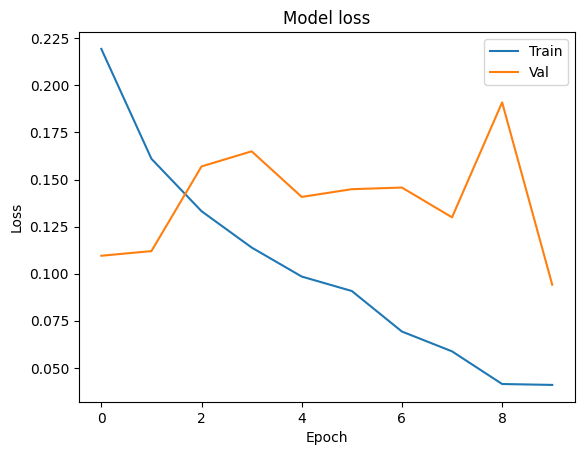

In [486]:
# Plot the change of loss during training
plt.plot(history['train_loss'])
plt.plot(history['val_val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='upper right')
plt.show()

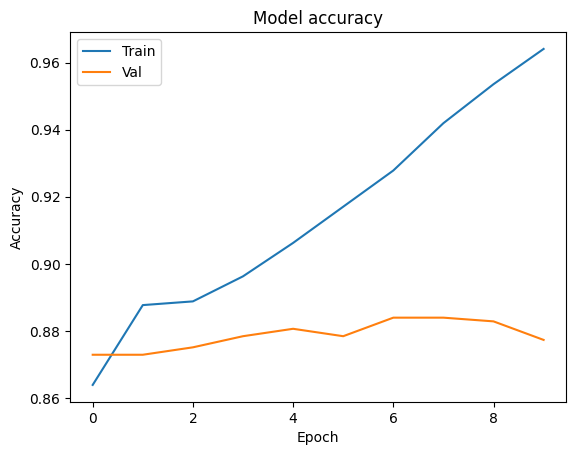

In [487]:
# Plot the change of accuracy during training
plt.plot(history['train_BinaryAccuracy'])
plt.plot(history['val_BinaryAccuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

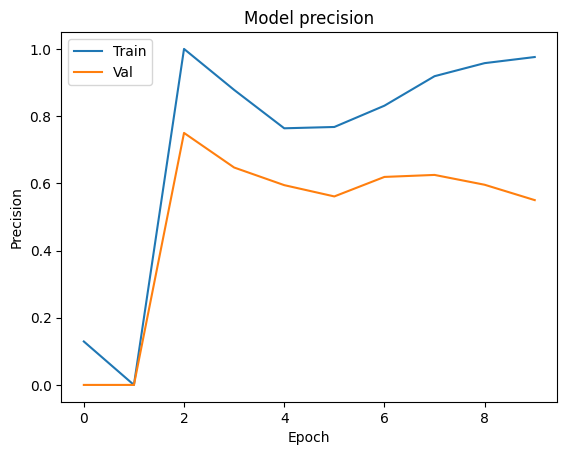

In [488]:
# Plot the change of precision during training
plt.plot(history['train_BinaryPrecision'])
plt.plot(history['val_BinaryPrecision'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

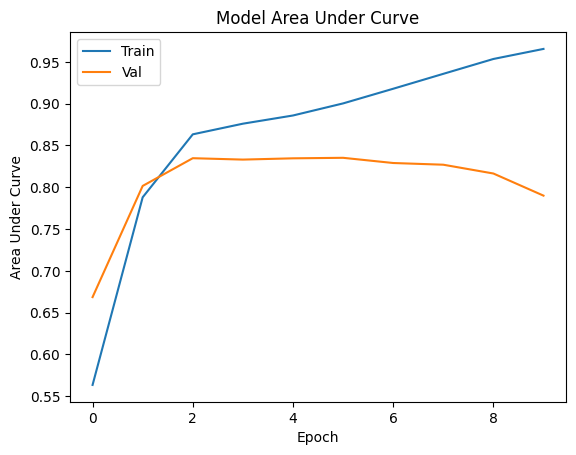

In [489]:
# Plot the Area Under Curve(AUC) of loss during training
plt.plot(history['train_BinaryAUROC'])
plt.plot(history['val_BinaryAUROC'])
plt.title('Model Area Under Curve')
plt.ylabel('Area Under Curve')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [490]:
global_metric = sl_model.evaluate(test_data, test_label, batch_size=128)

Evaluate Processing:: 100%|██████████| 8/8 [00:00<00:00, 110.04it/s, val_loss:0.18039482831954956 BinaryAccuracy:0.8662983179092407 BinaryPrecision:0.43478259444236755 BinaryAUROC:0.7920967936515808]


## Compare to local model

#### Model  
Here, we use the same model structure as the one used in the split learning example, but only the model structure for Alice is used in this case. The code for defining the model is shown below.  
#### Data  
The data also use kaggle's anti-fraud data. Here, we just use Alice's data of the new bank.  
1. The total sample size was 11162, including 8929 training set and 2233 test set.  
2. The feature dimension is 4.  

In [491]:
class Single_Model(BaseModule):
    def __init__(self):
        super(Single_Model,self).__init__()
        self.layer1=nn.Linear(4,100)
        self.layer2=nn.ReLU()
        self.layer3=nn.Linear(100,64)
        self.layer4=nn.ReLU()
        self.layer5=nn.Linear(64,64)
        self.layer6=nn.ReLU()
        self.layer7=nn.Linear(64,1)
        self.layer8=nn.Sigmoid()
        
        
    def forward(self, x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.layer5(x)
        x=self.layer6(x)
        x=self.layer7(x)
        out=self.layer8(x)
        return out

single_model=Single_Model()

Data process

In [492]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
single_part_data = alice_data.copy()

single_part_data['job'] = encoder.fit_transform(alice_data['job'])
single_part_data['marital'] = encoder.fit_transform(alice_data['marital'])
single_part_data['education'] = encoder.fit_transform(alice_data['education'])
single_part_data['y'] = encoder.fit_transform(alice_data['y'])

In [493]:
y = single_part_data['y']
alice_data = single_part_data.drop(columns=['y'], inplace=False)

In [494]:
scaler = MinMaxScaler()
alice_data = scaler.fit_transform(alice_data)

In [495]:
train_data, test_data = train_test_split(
    alice_data, train_size=0.8, random_state=random_state
)
train_label, test_label = train_test_split(y, train_size=0.8, random_state=random_state)
train_data=train_data.astype('float32')
test_data=test_data.astype('float32')
train_label=train_label.astype('float32')
test_label=test_label.astype('float32')

In [496]:
from torch.utils.data import Dataset,DataLoader

class Bank_Dataset(Dataset):
    def __init__(self,data,label):
        self.data=data
        self.label=label
    def __len__(self):
        return len(self.label)
    def __getitem__(self,index):
        return self.data[index],self.label.iloc[index]


train_dataset=Bank_Dataset(train_data,train_label)
test_dataset=Bank_Dataset(test_data,test_label)
train_dataloader=DataLoader(train_dataset,batch_size=128)
test_dataloader=DataLoader(test_dataset,batch_size=128)


In [497]:
optimizer=torch.optim.Adam(single_model.parameters(),lr=1e-2)
loss_fn=nn.BCELoss()
train_losses=[]
train_accs=[]
val_losses=[]
val_accs=[]
for epoch in range(10):
    single_model.train()
    train_loss=[]
    train_acc=[]
    for batch in train_dataloader:
        data,label=batch
        pred=single_model(data)
        pred=pred.squeeze()
        # print(pred.shape)
        
        loss=loss_fn(pred,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        predict = torch.where(pred>0.5,torch.ones_like(pred),torch.zeros_like(pred))
        acc=(predict==label).float().mean()
        train_loss.append(loss.item())
        train_acc.append(acc)
    train_loss=sum(train_loss)/len(train_loss)
    train_acc=sum(train_acc)/len(train_acc)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    single_model.eval()
    val_loss=[]
    val_acc=[]
    for batch in test_dataloader:
        data,label=batch
        pred=single_model(data)
        pred=pred.squeeze()
        loss=loss_fn(pred,label)
        predict = torch.where(pred>0.5,torch.ones_like(pred),torch.zeros_like(pred))
        acc=(predict==label).float().mean()
        val_loss.append(loss.item())
        val_acc.append(acc)
    val_loss=sum(val_loss)/len(val_loss)
    val_acc=sum(val_acc)/len(val_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

        

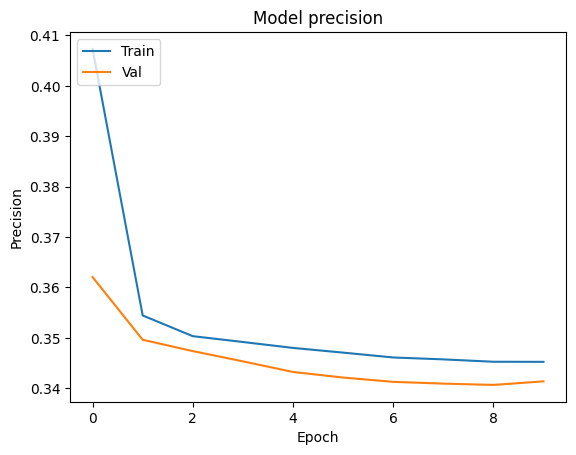

In [498]:
# single_model.evaluate(test_data, test_label, batch_size=128)
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

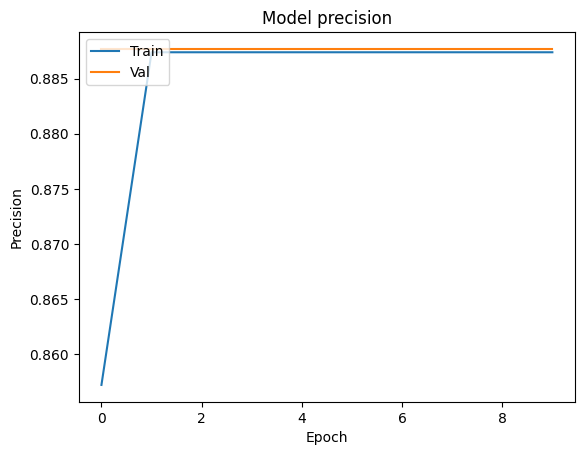

In [499]:
# single_model.evaluate(test_data, test_label, batch_size=128)
plt.plot(train_accs)
plt.plot(val_accs)
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Conclusion

* This tutorial introduces what is split learning and how to do it in secretFlow.  
* It can be seen from the experimental data that split learning has significant advantages in expanding sample dimension and improving model effect through joint multi-party training.
* This tutorial uses plaintext aggregation to demonstrate, without considering the leakage problem of hidden layer. Secretflow provides AggLayer to avoid the leakage problem of hidden layer plaintext transmission through MPC,TEE,HE, and DP. If you are interested, please refer to relevant documents.
* Next, you may want to try different data sets, you need to vertically shard the data first and then follow the flow of this tutorial.


## Acknowledgement
This work is finished by @dongdongzhaoUP with the help of @zhangxingmeng .